# 3D parameter estimation using MCMC

Leverages the data produced in `drifter_3D.ipynb`

In [1]:
import os
from tqdm import tqdm

import xarray as xr
import pandas as pd
import numpy as np
np.random.seed(1234)

from scipy import stats

import matplotlib.pyplot as plt

from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats
from gptide import mcmc
import corner
import arviz as az


data_dir = "data/"
data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

## Define kernels

In [2]:
#case = "matern2_iso_matern12_pp_a0.0_e0.2"
case = "matern32_iso_matern12_pp_r0.0_u0.2"

uv = True # True if u and v are observed
noise = 0.01 # observation noise added to u/v
no_time = False # activates time inference

In [3]:
# load drifters data
dsd = xr.open_dataset(os.path.join(data_dir, f"3D_{case}_parcels_selection.nc"))
dsd_full = (xr
    .open_dataset(os.path.join(data_dir, f"3D_{case}_parcels.nc"))
    .rename(lon="x", lat="y")
    .drop("z")
)
_t = (dsd_full["time"] - dsd_full["time"][0,0]).median("traj",skipna=True)/pd.Timedelta("1D")
dsd_full = dsd_full.assign_coords(t=_t)
dsd_full["x"] = dsd_full["x"]/1e3
dsd_full["y"] = dsd_full["y"]/1e3


# load eulerian flow
dsf = xr.open_dataset(os.path.join(data_dir, f"3D_{case}_flow_selection.nc")).sortby("trajectory")
dsf["time"] = dsf["time"]/pd.Timedelta("1D")
dsf0 = xr.open_dataset(os.path.join(data_dir, f"3D_{case}_flow.zarr"))
dsf_reduced = dsf0.sel(x=dsf.x, y=dsf.y).compute()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [4]:
# problem parameters (need to be consistent with data generation notebook)

p = dsd.attrs
# !! to adjust
η = p["amplitude0"]  # streamfunction unit
#η = p["amplitude1"]  # potential unit
#
λx = p["lambda_x"]   # km
λy = p["lambda_y"]   # km
λt = p["lambda_t"]   # days

Lx = float(dsf0.x.max()-dsf0.x.min())
Ly = float(dsf0.y.max()-dsf0.y.min())
# km, km this should not matter

In [5]:
from scipy.special import kv, kvp, gamma

# https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function

# copy from https://github.com/TIDE-ITRH/gptide/blob/main/gptide/cov.py
def matern_general(dx, eta, nu, l):
    """General Matern base function"""
    
    cff1 = np.sqrt(2*nu)*np.abs(dx)/l
    K = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu)
    K *= np.power(cff1, nu)
    K *= kv(nu, cff1)
    
    K[np.isnan(K)] = np.power(eta, 2.)
    
    return K

# new
def matern_general_d1(dx, eta, nu, l):
    """General Matern base function, first derivative"""
    
    cff0 = np.sqrt(2*nu)/l
    cff1 = cff0*np.abs(dx)
    K = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu) * cff0
    K *= (
        nu*np.power(cff1, nu-1)*kv(nu, cff1)
        + np.power(cff1, nu)*kvp(nu, cff1, n=1)
    )
    K[np.isnan(K)] = 0.
    # but remember K'(d)/d converge toward K''(0) towards 0
    
    return K

def matern_general_d2(dx, eta, nu, l):
    """General Matern base function, second derivative"""
    
    cff0 = np.sqrt(2*nu)/l
    cff1 = cff0*np.abs(dx)
    K = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu) * cff0**2
    K *= (
        nu*(nu-1)*np.power(cff1, nu-2)*kv(nu,cff1) 
        + 2*nu*np.power(cff1, nu-1)*kvp(nu,cff1, n=1)
        + np.power(cff1, nu)*kvp(nu, cff1, n=2)
    )
    K[np.isnan(K)] = -np.power(eta, 2.) * nu/(nu-1)/l**2
    
    return K


def matern32_d1(dx, eta, l):
    """Matern 3/2 function, first derivative"""
    
    cff0 = np.sqrt(3)/l
    cff1 = cff0*np.abs(dx)
    Kp = -np.power(eta, 2.)*cff0*cff1*np.exp(-cff1)
    
    return Kp

def matern32_d2(dx, eta, l):
    """Matern 3/2 function, second derivative"""
    
    cff0 = np.sqrt(3)/l
    cff1 = cff0*np.abs(dx)
    Kpp = np.power(eta, 2.) * cff0**2 *(-1+cff1)*np.exp(-cff1)
    
    return Kpp


In [6]:
isotropy = False
if p["cov_x"] == "matern12_xy":
    Cx = cov.matern12  # -2 spectral slope
    Cy = cov.matern12  # -2 spectral slope
elif p["cov_x"] == "matern32_xy":
    Cx = cov.matern32  # -4 spectral slope: not twice differentiable
    Cy = cov.matern32  # -4 spectral slope: 
elif p["cov_x"] == "matern2_xy":
    #Cov_x = cov.matern_general(np.abs(t_x - t_x.T), 1., 2, λx) # -5 spectral slope
    #Cov_y = cov.matern_general(np.abs(t_y - t_y.T), 1., 2, λy) # -5 spectral slope
    pass
elif p["cov_x"] == "matern52_xy":
    Cx = cov.matern52  # -6 spectral slope
    Cy = cov.matern52  # -6 spectral slope
elif p["cov_x"] == "expquad":
    #jitter = -10
    Cx = cov.expquad(t_x, t_x.T, λx) # + 1e-10 * np.eye(Nx)
    Cy = cov.expquad(t_y, t_y.T, λy) # + 1e-10 * np.eye(Nx)

# isotropic cases
isotropy = ("iso" in p["cov_x"])
#if p["cov_x"] == "matern2_iso" or True: # dev
if p["cov_x"] == "matern2_iso":
    nu = 2
    #nu = 3/2 # dev
    # for covariances based on distances
    def Cu(x, y, d, λ):
        C = -(
            y**2 * matern_general_d2(d, 1., nu, λ)
            + x**2 * matern_general_d1(d, 1., nu, λ) / d
        )/ d**2
        C[np.isnan(C)] = -matern_general_d2(d[np.isnan(C)], 1.0, nu, λ)
        return C
    def Cv(x, y, d, λ):
        C = -(
            x**2 * matern_general_d2(d, 1., nu, λ)
            + y**2 * matern_general_d1(d, 1., nu, λ) / d
        ) / d**2
        C[np.isnan(C)] = -matern_general_d2(d[np.isnan(C)], 1.0, nu, λ)
        return C
    def Cuv(x, y, d, λ):
        C = x*y*(
                matern_general_d2(d, 1., nu, λ)
                - matern_general_d1(d, 1., nu, λ) / d
            ) / d**2
        C[np.isnan(C)] = 0.
        return C
elif p["cov_x"] == "matern32_iso":
    # for covariances based on distances
    def Cu(x, y, d, λ):
        C = -(
            y**2 * matern32_d2(d, 1., λ)
            + x**2 * matern32_d1(d, 1., λ) / d
        )/ d**2
        C[np.isnan(C)] = -matern32_d2(d[np.isnan(C)], 1.0, λ)
        return C
    def Cv(x, y, d, λ):
        C = -(
            x**2 * matern32_d2(d, 1., λ)
            + y**2 * matern32_d1(d, 1., λ) / d
        ) / d**2
        C[np.isnan(C)] = -matern32_d2(d[np.isnan(C)], 1.0, λ)
        return C
    def Cuv(x, y, d, λ):
        C = x*y*(
                matern32_d2(d, 1., λ)
                - matern32_d1(d, 1., λ) / d
            ) / d**2
        C[np.isnan(C)] = 0.
        return C
# dev
#Cu, Cv, Cuv = (lambda x, y, d, λ: np.eye(*x.shape),)*3 

Ct = getattr(cov, p["cov_t"])

/dev/shm/pbs.7396688.datarmor0/ipykernel_50711/4160097073.py:53: RuntimeWarning: invalid value encountered in true_divide
  + x**2 * matern32_d1(d, 1., λ) / d
/dev/shm/pbs.7396688.datarmor0/ipykernel_50711/4160097073.py:60: RuntimeWarning: invalid value encountered in true_divide
  + y**2 * matern32_d1(d, 1., λ) / d
/dev/shm/pbs.7396688.datarmor0/ipykernel_50711/4160097073.py:67: RuntimeWarning: invalid value encountered in true_divide
  - matern32_d1(d, 1., λ) / d


Text(0.5, 1.0, 'uv covariance')

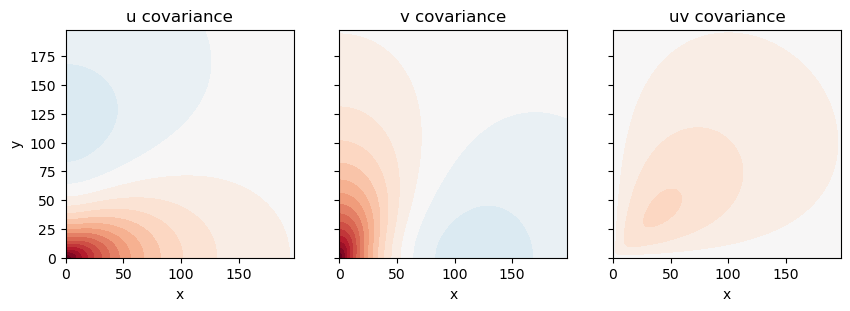

In [7]:
### inspect covariance

Nx, dx = 100, 2.  # km
Ny, dy = 100, 2.  # km
#Nt, dt = 100*24, 1/24  # days

t_x = np.arange(Nx)[:, None]*dx
t_y = np.arange(Ny)[:, None]*dy
#t_t = np.arange(Nt)[:, None]*dt

t_x2 = t_x   + t_y.T*0
t_y2 = t_x*0 + t_y.T  
t_d2 = np.sqrt(t_x2**2+t_y2**2)

Cov = xr.Dataset(
    dict(
        u=(("x", "y"), Cu(t_x2, t_y2, t_d2, λx)),
        v=(("x", "y"), Cv(t_x2, t_y2, t_d2, λx)),
        uv=(("x", "y"), Cuv(t_x2, t_y2, t_d2, λx)),
    ), 
                 
    coords=dict(x=("x", t_x[:,0]), y=("y", t_y[:,0]),),
)

cmax = max(
    float(np.abs(Cov.u).max()), 
    float(np.abs(Cov.v).max())
)
kwargs = dict(
    x="x", levels=30, vmax=cmax, vmin=-cmax, cmap="RdBu_r", add_colorbar=False,
)

fig, axes = plt.subplots(1,3, figsize=(10,5), sharey=True)
ax = axes[0]
Cov.u.plot.contourf(ax=ax, **kwargs)
ax.set_aspect("equal")
ax.set_title("u covariance")

ax = axes[1]
Cov.v.plot.contourf(ax=ax, **kwargs)
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_title("v covariance")

ax = axes[2]
Cov.uv.plot.contourf(ax=ax, **kwargs)
ax.set_aspect("equal")
ax.set_ylabel("")
ax.set_title("uv covariance")

#ax.set_title("u Covariance")


In [8]:
def kernel_3d(x, xpr, params):
    """
    3D kernel
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            lt: t length scale
            
    """
    eta, lx, ly, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= Cy(x[:,1,None], xpr.T[:,1,None].T, ly) 
    C *= Cx(x[:,0,None], xpr.T[:,0,None].T, lx)
    C *= eta**2
    
    return C

def kernel_3d_iso(x, xpr, params):
    """
    3D kernel
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            ld: spatial scale
            lt: t length scale
            
    """
    eta, ld, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    d = np.sqrt( (x[:,0,None]  - xpr.T[:,0,None].T)**2 + (x[:,1,None]  - xpr.T[:,1,None].T)**2 )
    C *= Cx(d, ld)
    C *= eta**2
    
    return C

def kernel_3d_iso_uv(x, xpr, params):
    """
    3D kernel, one velocity component
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            ld: spatial scale
            lt: t length scale
            
    """
    eta, ld, lt = params
    
    # Build the covariance matrix
    n = x.shape[0]//2
    _x = x[:n,0,None] - xpr.T[:n,0,None].T
    _y = x[:n,1,None] - xpr.T[:n,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )
    #
    C = np.ones((2*n,2*n))
    # test comment out
    C[:n,:n] *= Cu(_x, _y, _d, ld)
    #C[:n,n:] = C[:n,:n] # dev
    #C[n:,:n] = C[:n,:n] # dev
    #C[n:,n:] = C[:n,:n] # dev
    C[:n,n:] *= Cuv(_x, _y, _d, ld)
    C[n:,:n] = C[:n,n:]   # assumes X is indeed duplicated vertically
    C[n:,n:] *= Cv(_x, _y, _d, ld)
    #
    #_Cu  = Cu(_x, _y, _d, ld)
    #_Cv  = Cv(_x, _y, _d, ld)
    #_Cuv  = Cuv(_x, _y, _d, ld)
    #C *= np.block([[_Cu, _Cuv],[_Cuv, _Cv]])
    C *= Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= eta**2
    
    return C

def kernel_3d_iso_u(x, xpr, params):
    """
    3D kernel, one velocity component
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            ld: spatial scale
            lt: t length scale
            
    """
    eta, ld, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    _x = x[:,0,None] - xpr.T[:,0,None].T
    _y = x[:,1,None] - xpr.T[:,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )
    C *= Cu(_x, _y, _d, ld)
    C *= eta**2
    
    return C

def kernel_2d_iso_uv(x, xpr, params):
    """
    2D kernel (no time), one velocity component
    
    Inputs:
        x: matrices input points [N,2]
        xpr: matrices output points [M,2]
        params: tuple length 2
            eta: standard deviation
            ld: spatial scale
            
    """
    eta, ld = params
    
    # Build the covariance matrix
    n = x.shape[0]//2
    _x = x[:n,0,None] - xpr.T[:n,0,None].T
    _y = x[:n,1,None] - xpr.T[:n,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )
    #
    C = np.ones((2*n,2*n))
    # test comment out
    C[:n,:n] *= Cu(_x, _y, _d, ld)
    C[:n,n:] *= Cuv(_x, _y, _d, ld)
    C[n:,:n] = C[:n,n:]   # assumes X is indeed duplicated vertically
    C[n:,n:] *= Cv(_x, _y, _d, ld)
    #
    C *= eta**2
    
    return C


def kernel_2d_iso_u(x, xpr, params):
    """
    2D kernel, one velocity component
    
    Inputs:
        x: matrices input points [N,2]
        xpr: matrices output points [M,2]
        params: tuple length 2
            eta: standard deviation
            ld: spatial scale
            
    """
    eta, ld = params
    
    # Build the covariance matrix
    _x = x[:,0,None] - xpr.T[:,0,None].T
    _y = x[:,1,None] - xpr.T[:,1,None].T
    _d = np.sqrt( _x**2 + _y**2 )
    C = Cu(_x, _y, _d, ld)
    C *= eta**2
    
    return C

def kernel_1d(x, xpr, params):
    """
    1D kernel - temporal
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 4
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            lt: t length scale
            
    """
    eta, lt = params
    
    # Build the covariance matrix
    C  = Ct(x[:,2,None], xpr.T[:,2,None].T, lt)
    C *= eta**2
    
    return C

---

## Inference: fixed points -  space/time

We now use the `gptide.mcmc` function do the parameter estimation. This uses the `emcee.EnsembleSampler` class.


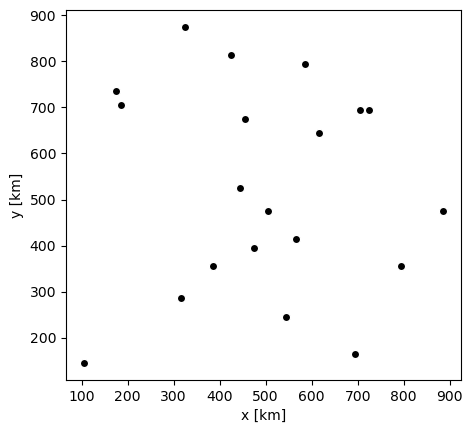

In [9]:
fig, ax = plt.subplots(1,1)
dsf.plot.scatter(x="x",y="y", c="k", ax=ax)
ax.set_aspect("equal")

In [10]:
# load data
ds = dsf
dt0 = float(np.unique(ds.time.diff("time"))[0])
print(f"initial time sampling rate {dt0:.3f} days")

initial time sampling rate 0.042 days


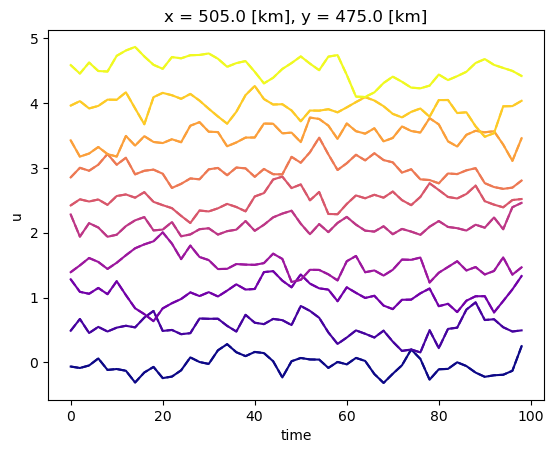

In [11]:
# decimate
if no_time:
    npts = 100
    dl = 200
    ds = (dsf0
        .isel(time=0)
        .sel(x=slice(500-dl,500+dl), y=slice(500-dl,500+dl))
        .stack(trajectory=["x", "y"])
        .rename(U="u", V="v")
    )
    ds.u.unstack().plot()
    #
    narrow_selection = np.random.choice(ds.trajectory.values, npts)
    ds = ds.sel(trajectory=narrow_selection)
    #ds.unstack().psi.plot()
else:
    ds = ds.sel(time=slice(0, None, int(2/dt0)))   # temporally
    ds = ds.isel(trajectory=slice(0, None, 2))    # spatially
    #
    #da = ds.u
    #da  = da + np.arange(ds.trajectory.size)/5
    #da.plot(hue="trajectory", add_legend=False, figsize=(5,7));
    col = plt.get_cmap('plasma')
    n = ds.trajectory.size
    for i, t in enumerate(ds.trajectory):
        (ds.sel(trajectory=t).u+i/2).plot(x="time", color=col(i/(n-1)))
        (ds.sel(trajectory=t).u+i/2).plot(x="time", color=col(i/(n-1)), ls="--")
    ax.set_title("u & v for a trajectory selection")    

In [12]:
# number of data points
N = ds.u.size
Nxy = ds.trajectory.size
print(f"Number of data points = {N}, ({Nxy} spatial locations)")

# problem parameters (need to be consistent with data generation notebook)
if not no_time:
    Lt = float(ds.time.max()-ds.time.min()) # days

# estimate effective resolution
δx = Lx/Nxy
δy = Ly/Nxy
print("-- resolutions:")
print(f"λx/δx = {λx/δx}")
print(f"λy/δy = {λy/δy}")
if not no_time:
    δt = float(ds.time.diff("time")[0])
    print(f"λt/δt = {λt/δt}")

# estimate number of independent samples
print("-- independent samples (conservative):")
print(f"Lx/λx = {Lx/λx} ") # this is probably conservative
print(f"Ly/λy = {Ly/λy} ") # this is probably conservative
if not no_time:
    print(f"Lt/λt = {Lt/λt} ") # this is probably conservative

Number of data points = 500, (10 spatial locations)
-- resolutions:
λx/δx = 1.0101010101010102
λy/δy = 1.0101010101010102
λt/δt = 2.5
-- independent samples (conservative):
Lx/λx = 9.9 
Ly/λy = 9.9 
Lt/λt = 19.6 


In [13]:
if no_time:
    u, v, x, y = xr.broadcast(ds.u, ds.v, ds.x, ds.y)
    assert u.shape==v.shape==x.shape==y.shape
    x = x.values.ravel()
    y = y.values.ravel()
    X = np.hstack([x[:,None], y[:,None],])
else:
    u, v, x, y, t = xr.broadcast(ds.u, ds.v, ds.x, ds.y, ds.time)
    assert u.shape==v.shape==x.shape==y.shape==t.shape
    x = x.values.ravel()
    y = y.values.ravel()
    t = t.values.ravel()
    X = np.hstack([x[:,None], y[:,None], t[:,None]])
    
u = u.values.ravel()[:, None]
v = v.values.ravel()[:, None]

# add noise
u += np.random.randn(*u.shape)*noise
v += np.random.randn(*v.shape)*noise

if uv:
    X = np.vstack([X, X])
    U = np.vstack([u, v])
else:
    U = u


# dev
#X = X[::10,:]
#U = U[::10]
    
print(X.shape, U.shape)


(1000, 3) (1000, 1)


In [14]:
# set covariance parameters
if no_time:
    if uv:
        covfunc = kernel_2d_iso_uv
    else:
        covfunc = kernel_2d_iso_u
    covparams = [η, λx]
    labels = ['σ','η','λx',]
elif isotropy:
    if uv:
        covfunc = kernel_3d_iso_uv
    else:
        covfunc = kernel_3d_iso_u
    covparams = [η, λx, λt]
    labels = ['σ','η','λx','λt']
else:
    covfunc = kernel_3d
    covparams = [η, λx, λy, λt]
    labels = ['σ','η','λx','λy','λt']


In [15]:
# v0 of the inference

def inference0():

    # Initial guess of the noise and covariance parameters (these can matter)
    if no_time:
        noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise
        covparams_priors = [gpstats.truncnorm(η, η*2, η/10, η*10),                   # eta
                            gpstats.truncnorm(λx, λx*2, λx/10, λx*10),               # λx
                           ]
    elif isotropy:
        noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise
        covparams_priors = [gpstats.truncnorm(η, η*2, η/10, η*10),                   # eta
                            gpstats.truncnorm(λx, λx*2, λx/10, λx*10),               # λx
                            gpstats.truncnorm(λt, λt*2, λt/10, λt*10),               # λt
                           ]
    else:
        noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise
        covparams_priors = [gpstats.truncnorm(η, η*2, η/10, η*10),                   # eta
                            gpstats.truncnorm(λx, λx*2, λx/10, λx*10),               # λx
                            gpstats.truncnorm(λy, λy*2, λy/10, λy*10),               # λy
                            gpstats.truncnorm(λt, λt*2, λt/10, λt*10),               # λt
                           ]

    samples, log_prob, priors_out, sampler = mcmc.mcmc(
        X,
        U,
        covfunc,
        covparams_priors,
        noise_prior,
        nwarmup=100,
        niter=100,
        verbose=False,
    )

    # 40 points
    # with bessels: 2min30, 1.6s / iteration
    # without bessels: 19s, 5 iterations / second
    # with one bessel: 1min05 , 1.5 iteration / second
    # with eye instead of bessel: 20s, 4.7 iterations / second

    # mattern32 - analytical:      24s , 4 iterations per second
    # mattern32 - bessel:      1min32s , 1 iteration  per second

    # 1000 points, mattern32 - analytical: 1 hour total - 30s / iteration

    # should also store prior information
    ds = xr.Dataset(
        dict(samples=(("i", "parameter"), samples),
             priors=(("j", "parameter"), priors_out),
             log_prob=("i", log_prob.squeeze()),
            ),
        coords=dict(parameter=labels)
    )
    ds.attrs["inference"] = "v0"

    # MAP
    i_map = int(ds["log_prob"].argmax())
    ds["MAP"] = ds["samples"].isel(i=i_map)
    ds.attrs["i_MAP"] = i_map
    #i = np.argmax(log_prob)
    #MAP = samples[i, :]

    return ds

In [16]:
# v1 of inference

# what is the prior distribution?
# what is the posterior distribution? right now: discard rejected samples and estimate from remaining ones

#n_mcmc = int(2e3)
def inference1(
        n_mcmc = int(2e3),
    ):
    
    # The order of everything is eta, ld, lt, noise

    step_sizes = np.array([.5, 5, .5, 0.005])
    initialisations = np.array([12, 100, 5, 0.01])
    lowers = np.repeat(0, 4)
    uppers = np.array([100, 1000, 100, 0.05])

    # setup objects
    eta_samples = np.empty(n_mcmc)
    ld_samples = np.empty(n_mcmc)
    lt_samples = np.empty(n_mcmc)
    noise_samples = np.empty(n_mcmc)
    accept_samples = np.empty(n_mcmc)
    lp_samples = np.empty(n_mcmc)

    eta_samples[0] = initialisations[0]
    ld_samples[0] = initialisations[1]
    lt_samples[0] = initialisations[2]
    noise_samples[0] = initialisations[3]
    accept_samples[0] = 0

    covparams_curr = initialisations.copy()[0:3]
    covparams_prop = initialisations.copy()[0:3]    

    # run mcmc
    gp_current = GPtideScipy(X, X, noise, covfunc, covparams)

    for i in tqdm(np.arange(1, n_mcmc)):

        eta_proposed = np.random.normal(eta_samples[i-1], step_sizes[0], 1)
        ld_proposed = np.random.normal(ld_samples[i-1], step_sizes[1], 1)
        lt_proposed = np.random.normal(lt_samples[i-1], step_sizes[2], 1)
        noise_proposed = np.random.normal(noise_samples[i-1], step_sizes[3], 1)

        proposed = np.array([eta_proposed, ld_proposed, 
                             lt_proposed, noise_proposed])

        if ((proposed.T <= lowers) | (proposed.T >= uppers)).any():
            eta_samples[i] = eta_samples[i-1]
            ld_samples[i] = ld_samples[i-1]
            lt_samples[i] = lt_samples[i-1]
            noise_samples[i] = noise_samples[i-1]
            accept_samples[i] = 0
            continue

        if accept_samples[i-1] == True:
            gp_current = gp_proposed

        covparams_prop = np.array([eta_proposed, ld_proposed, lt_proposed])
        gp_proposed = GPtideScipy(X, X, noise_proposed, kernel_3d_iso_uv, covparams_prop)

        lp_current = gp_current.log_marg_likelihood(U)
        lp_proposed = gp_proposed.log_marg_likelihood(U)

        alpha = np.min([1, np.exp(lp_proposed - lp_current)])
        u = np.random.uniform()

        if alpha > u:
            eta_samples[i] = eta_proposed
            ld_samples[i] = ld_proposed
            lt_samples[i] = lt_proposed
            noise_samples[i] = noise_proposed
            accept_samples[i] = 1
            lp_samples[i] = lp_proposed
        else:
            eta_samples[i] = eta_samples[i-1]
            ld_samples[i] = ld_samples[i-1]
            lt_samples[i] = lt_samples[i-1]
            noise_samples[i] = noise_samples[i-1]
            accept_samples[i] = 0
            lp_samples[i] = lp_samples[i-1]

    #print(np.mean(accept_samples))

    samples = np.vstack((noise_samples, eta_samples, ld_samples, lt_samples))
    ds = xr.Dataset(
        dict(
            samples=(("i", "parameter"), samples.T), 
            accept=("i", accept_samples),
            log_prob=("i", lp_samples),
            init=(("parameter",), np.roll(initialisations,1)), # need to swap parameter orders
            lower=(("parameter",), np.roll(lowers,1)),
            upper=(("parameter",), np.roll(uppers,1)),
        ),
        coords=dict(parameter=labels)
    )

    #return noise_samples, eta_samples, ld_samples, lt_samples, 
    accepted_fraction = float(ds["accept"].mean())

    # keep only accepted samples
    ds = ds.where(ds.accept==1, drop=True)

    # MAP
    i_map = int(ds["log_prob"].argmax())
    ds["MAP"] = ds["samples"].isel(i=i_map)

    ds.attrs["accepted_fraction"] = accepted_fraction
    ds.attrs["inference"] = "v1"
    ds.attrs["i_MAP"] = i_map

    return ds

In [17]:
# common utils

def print_MAP(ds):

    MAP = ds.MAP.values

    print('noise (true): {:3.2f},  noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
    print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
    print('λx (true):   {:3.2f},   λx   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
    if not isotropy:
        print('λy (true):   {:3.2f},   λy   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3])) 
    if not no_time:
        print('λt (true):   {:3.2f},   λt   (mcmc): {:3.2f}'.format(covparams[-1],  MAP[-1]))     
        
def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

def plot_inference(ds):

    samples = ds.samples.values
    samples_az = convert_to_az(samples, labels)
    
    density_data = [samples_az[labels],]
    density_labels = ['posterior',]
    if "priors" in ds:
        priors_out_az = convert_to_az(ds["priors"].values, labels)
        density_data += [priors_out_az[labels]]
        density_labels += ["prior"]
    
    axs = az.plot_density(   density_data,
                             shade=0.1,
                             grid=(1, 5),
                             textsize=12,
                             figsize=(12,3),
                             data_labels=tuple(density_labels),
                             hdi_prob=0.995)

    for t, m, ax in zip([noise,]+list(covparams), ds["MAP"], axs[0]):
        #print(t, ax)
        ax.axvline(t, color="k", ls="-") # true value
        ax.axvline(m, color="b", ls="-") # MAP
        ax.set_xlim(0, t*3)    
        
    fig = corner.corner(samples, 
                        show_titles=True,
                        labels=labels,
                        plot_datapoints=True,
                        quantiles=[0.16, 0.5, 0.84])
    
def plot_logprob(ds):
    fig, ax = plt.subplots(1,1)
    ds["log_prob"].plot(ax=ax)
    ax.axvline(ds.attrs["i_MAP"], color="k", lw=4)

In [18]:
# run inferences

In [19]:
ds0 = inference0()

Running burn-in...


/dev/shm/pbs.7396688.datarmor0/ipykernel_50711/4160097073.py:53: RuntimeWarning: invalid value encountered in true_divide
  + x**2 * matern32_d1(d, 1., λ) / d
/dev/shm/pbs.7396688.datarmor0/ipykernel_50711/4160097073.py:67: RuntimeWarning: invalid value encountered in true_divide
  - matern32_d1(d, 1., λ) / d
/dev/shm/pbs.7396688.datarmor0/ipykernel_50711/4160097073.py:60: RuntimeWarning: invalid value encountered in true_divide
  + y**2 * matern32_d1(d, 1., λ) / d
100%|██████████| 100/100 [22:32<00:00, 13.52s/it]


Running production...


100%|██████████| 100/100 [21:39<00:00, 13.00s/it]


In [20]:
ds1 = inference1()

/dev/shm/pbs.7396688.datarmor0/ipykernel_50711/4160097073.py:53: RuntimeWarning: invalid value encountered in true_divide
  + x**2 * matern32_d1(d, 1., λ) / d
/dev/shm/pbs.7396688.datarmor0/ipykernel_50711/4160097073.py:67: RuntimeWarning: invalid value encountered in true_divide
  - matern32_d1(d, 1., λ) / d
/dev/shm/pbs.7396688.datarmor0/ipykernel_50711/4160097073.py:60: RuntimeWarning: invalid value encountered in true_divide
  + y**2 * matern32_d1(d, 1., λ) / d
100%|██████████| 1999/1999 [05:23<00:00,  6.17it/s]


## original inference method (v0)

noise (true): 0.01,  noise (mcmc): 0.03
η   (true):   11.55,  η     (mcmc): 9.52
λx (true):   100.00,   λx   (mcmc): 93.44
λt (true):   5.00,   λt   (mcmc): 5.33


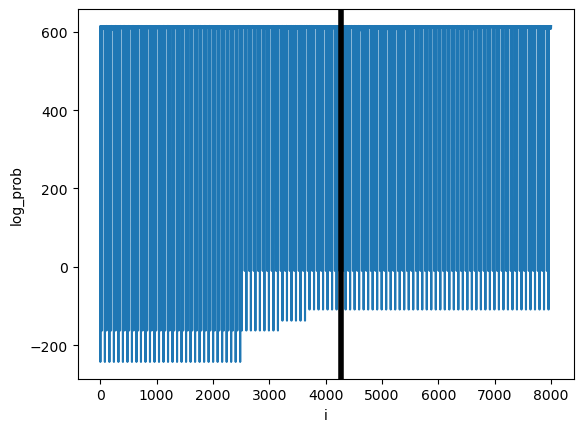

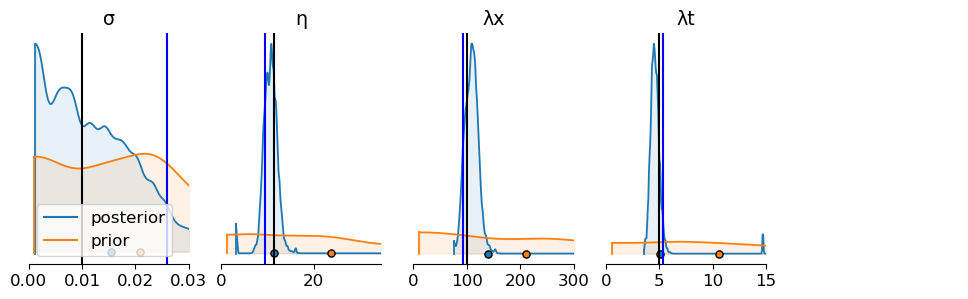

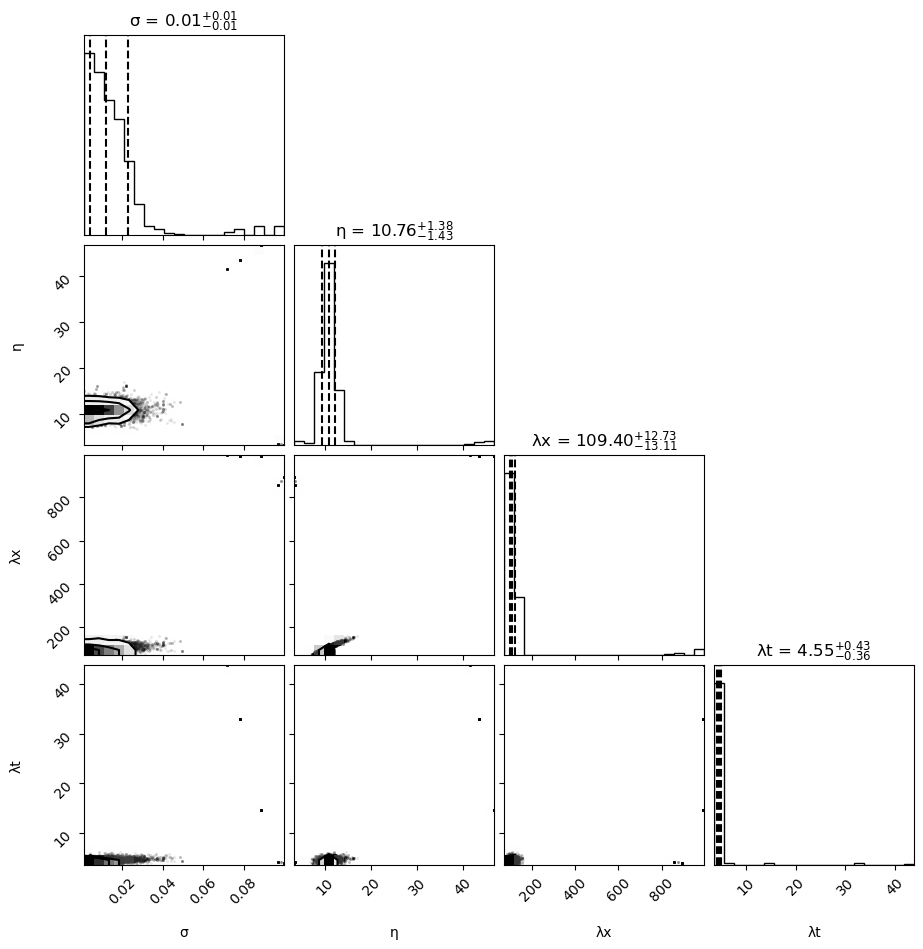

In [23]:
print_MAP(ds0)
plot_logprob(ds0)
plot_inference(ds0)

## new inference method (v1)

noise (true): 0.01,  noise (mcmc): 0.00
η   (true):   11.55,  η     (mcmc): 10.42
λx (true):   100.00,   λx   (mcmc): 105.82
λt (true):   5.00,   λt   (mcmc): 4.50


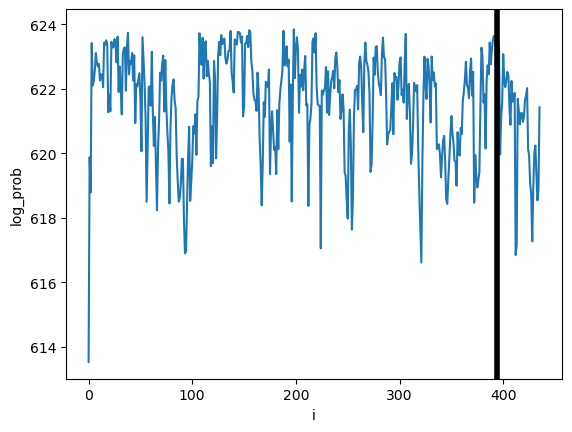

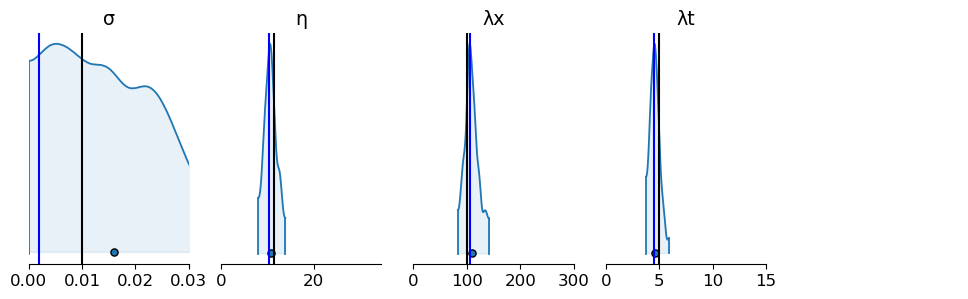

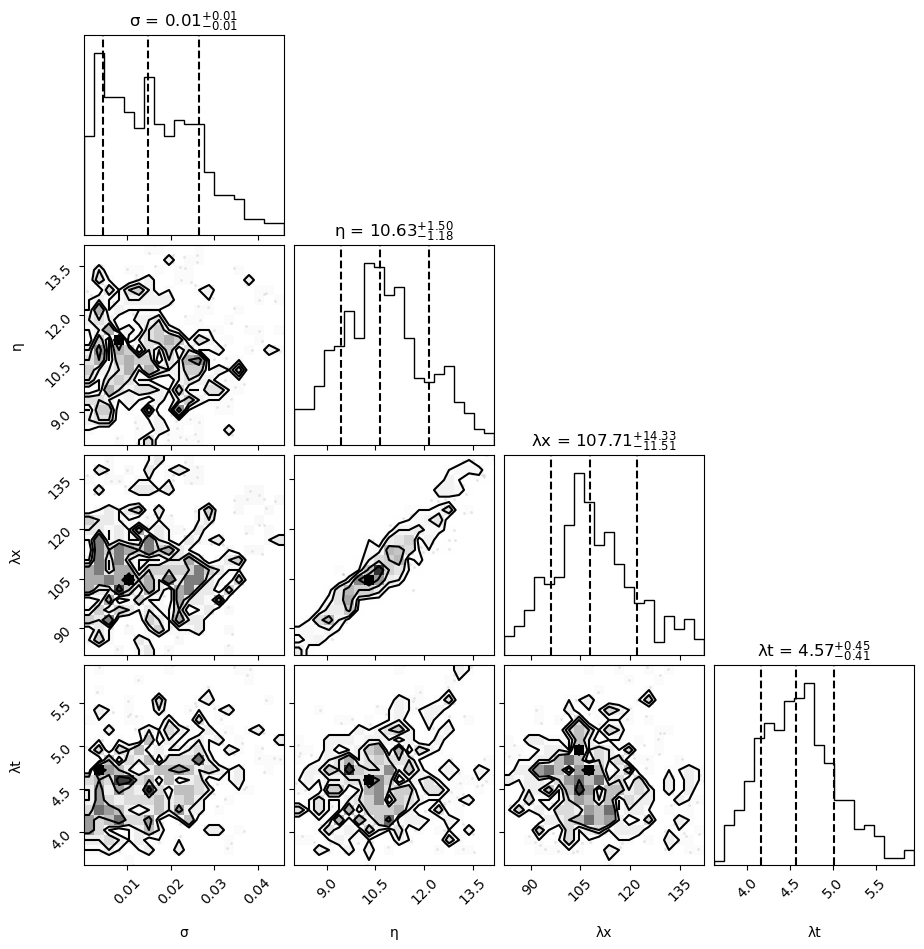

In [24]:
print_MAP(ds1)
plot_logprob(ds1)
plot_inference(ds1)

---

# ! do not look passed this point

---

## Inference: drifters - space/time

In [19]:
# load data
#ds = xr.open_dataset("data/parcels_3D_selection.nc", decode_times=False)
ds = dsd

dt0 = float(np.median(ds.time.diff("time")))
print(f"initial time sampling rate {dt0:.03f} days")

#ds

initial time sampling rate 0.042 days


In [20]:
# decimate
ds = (
    ds
    .isel(time=slice(0, -50, int(2/dt0)))   # temporally
    .isel(trajectory=slice(0, None, 2))    # spatially
)

In [ ]:
col = plt.get_cmap('plasma')
n = ds.trajectory.size

fig, ax = plt.subplots(1,1)
#da = ds.u
#da  = da + xr.ones_like(ds.trajectory).cumsum("trajectory")/5
for i, t in enumerate(ds.trajectory):
    _ds = ds.sel(trajectory=t)
    (_ds.u + t/5).plot(ax=ax, color=col(i/(n-1)))
    #da.plot(hue="trajectory", add_legend=False, figsize=(5,7));

fig, ax = plt.subplots(1,1)
for i, t in enumerate(ds.trajectory):
    _ds = ds.sel(trajectory=t)
    ax.plot(_ds.x, _ds.y, color=col(i/(n-1)))
    #(+i/2).plot(x="time", color=p(i/(n-1)))
    #(ds.sel(trajectory=t).u+i/2).plot(x="time", color=p(i/(n-1)), ls="--")
ax.set_aspect("equal")
#ax.set_title("u & v for a trajectory selection")    


#ax.scatter(ds.x, ds.y)
#for tr in ds.trajectory:
#    _ds = ds.sel(trajectory=tr)
#    ax.plot(_ds.x, _ds.y)
#    ds.scatter.plot("x", "y", hue="trajectory", ax=ax)
#ax.set_aspect("equal")

In [22]:
# number of data points
N = ds.u.size
Nxy = ds.trajectory.size
print(f"Number of data points = {N}, ({Nxy} drifters)")

# problem parameters (need to be consistent with data generation notebook)
Lt = float(ds.time.max()-ds.time.min()) # days

# estimate effective resolution
δx = Lx/Nxy
δy = Ly/Nxy
δt = float(ds.time.diff("time")[0])
print("-- resolutions:")
print(f"λx/δx = {λx/δx}")
print(f"λy/δy = {λy/δy}")
print(f"λt/δt = {λt/δt}")

# estimate number of independent samples
print("-- independent samples (conservative):")
print(f"Lx/λx = {Lx/λx} ") # this is probably conservative
print(f"Ly/λy = {Ly/λy} ") # this is probably conservative
print(f"Lt/λt = {Lt/λt} ") # this is probably conservative

Number of data points = 500, (10 drifters)
-- resolutions:
λx/δx = 1.0101010101010102
λy/δy = 1.0101010101010102
λt/δt = 2.5531914893617023
-- independent samples (conservative):
Lx/λx = 9.9 
Ly/λy = 9.9 
Lt/λt = 19.191666666666666 


In [23]:
# massage inputs to inference problem
u, v, x, y, t = xr.broadcast(ds.u, ds.v, ds.x, ds.y, ds.time)
assert u.shape==x.shape==y.shape==t.shape
x = x.values.ravel()
y = y.values.ravel()
t = t.values.ravel()

X = np.hstack([x[:,None], y[:,None], t[:,None]])

u = u.values.ravel()[:, None]
v = v.values.ravel()[:, None]

# add noise
u += np.random.randn(*u.shape)*noise
v += np.random.randn(*v.shape)*noise

if uv:
    X = np.vstack([X, X])
    U = np.vstack([u, v])
else:
    U = u

print(X.shape, U.shape)

(1000, 3) (1000, 1)


### actually perform inference

In [24]:
samples, log_prob, priors_out, sampler = mcmc.mcmc(
    X,
    U,
    covfunc,
    covparams_priors,
    noise_prior,
    nwarmup=100,
    niter=100,
    verbose=False,
)

Running burn-in...


/dev/shm/pbs.6361094.datarmor0/ipykernel_4656/4160097073.py:53: RuntimeWarning: invalid value encountered in true_divide
  + x**2 * matern32_d1(d, 1., λ) / d
/dev/shm/pbs.6361094.datarmor0/ipykernel_4656/4160097073.py:67: RuntimeWarning: invalid value encountered in true_divide
  - matern32_d1(d, 1., λ) / d
/dev/shm/pbs.6361094.datarmor0/ipykernel_4656/4160097073.py:60: RuntimeWarning: invalid value encountered in true_divide
  + y**2 * matern32_d1(d, 1., λ) / d
100%|██████████| 100/100 [24:09<00:00, 14.49s/it]


Running production...


100%|██████████| 100/100 [23:45<00:00, 14.25s/it]


In [25]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('noise (true): {:3.2f},  noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('λx (true):   {:3.2f},   λx   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))
if not isotropy:
    print('λy (true):   {:3.2f},   λy   (mcmc): {:3.2f}'.format(covparams[2],  MAP[3])) 
if not no_time:
    print('λt (true):   {:3.2f},   λt   (mcmc): {:3.2f}'.format(covparams[-1],  MAP[-1]))

noise (true): 0.01,  noise (mcmc): 0.01
η   (true):   14.14,  η     (mcmc): 11.37
λx (true):   100.00,   λx   (mcmc): 93.50
λt (true):   5.00,   λt   (mcmc): 5.19


In [ ]:
if isotropy:
    if no_time:
        labels = ['σ','η','λx',]
    else:
        labels = ['σ','η','λx', 'λt']
else:
    labels = ['σ', 'η', 'λx', 'λy', 'λt']

def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

for t, m, ax in zip([noise,]+list(covparams), MAP, axs[0]):
    print(t, ax)
    ax.axvline(t, color="k", ls="-")
    ax.axvline(m, color="b", ls="-")
    #ax.set_xlim(0, t*2)

In [ ]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

---

## Inference: drifters - time only

In [104]:
# Initial guess of the noise and covariance parameters (these can matter)

_η = p["eta"] # need to recall velocity amplitude here, not streamfunction one

covfunc = kernel_1d
covparams = [_η, λt]
noise_prior      = gpstats.truncnorm(noise, noise*2, noise/10, noise*10)     # noise
covparams_priors = [gpstats.truncnorm(_η, _η*2, _η/10, _η*10),                   # eta
                    gpstats.truncnorm(λt, λt*2, λt/10, λt*10),               # λt
                   ]

In [105]:
# load data
ds = dsd

dt0 = float(np.median(ds.time.diff("time")))
print(f"initial time sampling rate {dt0} days")

# decimate
ds = ds.sel(time=slice(0, None, int(1/dt0)))   # temporally
#ds = ds.isel(trajectory=slice(0, None, 1))    # spatially

# select one drifter:
ds = ds.isel(trajectory=0)

ds

initial time sampling rate 0.04166666666666696 days


<xarray.Dataset>
Dimensions:  (time: 104)
Coordinates:
  * time     (time) float64 0.0 0.9583 1.917 2.875 ... 95.83 96.79 97.75 98.71
Data variables:
    y        (time) float32 ...
    x        (time) float32 ...
    u        (time) float64 -0.2382 -0.05576 0.07991 ... -0.2384 -0.2206 -0.1537
    v        (time) float64 0.216 0.1322 -0.107 ... 0.05221 0.003476 -0.045
Attributes: (12/17)
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.0
    parcels_mesh:           flat
    eta:                    0.2
    ...                     ...
    cov_t:                  matern12
    kind:                   pp
    amplitude0:             14.142135623730951
    amplitude1:             0.0
    alpha:                  0.0
    noise:                  0.0

In [106]:
# should estimate effective number of points ...

In [107]:
u, x, y, t = xr.broadcast(ds.u, ds.x, ds.y, ds.time)
assert u.shape==x.shape==y.shape==t.shape
x = x.values.ravel()
y = y.values.ravel()
t = t.values.ravel()

X = np.hstack([x[:,None], y[:,None], t[:,None]])
u = ds.u.values.ravel()[:, None]

# add noise
u += np.random.randn(*u.shape)*noise

print(X.shape, u.shape)

(104, 3) (104, 1)


In [108]:
samples, log_prob, priors_out, sampler = mcmc.mcmc(
    X,
    u,
    covfunc,
    covparams_priors,
    noise_prior,
    nwarmup=100,
    niter=100,
    verbose=False,
)

Running burn-in...


100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


Running production...


100%|██████████| 100/100 [00:08<00:00, 11.69it/s]


In [109]:
i = np.argmax(log_prob)
MAP = samples[i, :]

print('noise (true): {:3.2f},  noise (mcmc): {:3.2f}'.format(noise, MAP[0]))
print('η   (true):   {:3.2f},  η     (mcmc): {:3.2f}'.format(covparams[0],  MAP[1]))
print('λt (true):   {:3.2f},   λt   (mcmc): {:3.2f}'.format(covparams[1],  MAP[2]))

noise (true): 0.01,  noise (mcmc): 0.02
η   (true):   0.20,  η     (mcmc): 0.21
λt (true):   5.00,   λt   (mcmc): 1.84


In [ ]:
labels = ['σ', 'η', 'λt']

def convert_to_az(d, labels):
    output = {}
    for ii, ll in enumerate(labels):
        output.update({ll:d[:,ii]})
    return az.convert_to_dataset(output)

priors_out_az = convert_to_az(priors_out, labels)
samples_az    = convert_to_az(samples, labels)

axs = az.plot_density(   [samples_az[labels], 
                         priors_out_az[labels]],
                         shade=0.1,
                         grid=(1, 5),
                         textsize=12,
                         figsize=(12,3),
                         data_labels=('posterior','prior'),
                         hdi_prob=0.995)

for t, m, ax in zip([noise,]+list(covparams), MAP, axs[0]):
    print(t, ax)
    ax.axvline(t, color="k", ls="-")
    ax.axvline(m, color="b", ls="-")
    #ax.set_xlim(0, t*2)

In [ ]:
fig = corner.corner(samples, 
                    show_titles=True,
                    labels=labels,
                    plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84])

### inference fixed-points ... to be done

---
### empirical spectra

In [52]:
import pynsitu as pin

In [11]:
Ed = dsd.ts.spectrum(method='periodogram', include=["u", "v"], detrend="linear")
Ef = dsf.ts.spectrum(method='periodogram', include=["u", "v"], detrend="linear")

In [12]:
#eta = float(dsd.u.std())
eta = η/λx
if p["cov_t"]=="matern12":
    nu = 1/2
elif p["cov_t"]=="matern32":
    nu = 3/2
E_input = cov.matern_spectra(Ed.frequency, eta, nu, λt)

In [13]:
# interpolate eulerian field on a finer timeline
#dsf_full_interp = dsf.resample(time="1H").interpolate()
#Ef_interp = dsf_full_interp.ts.spectrum(method='periodogram', include=["U", "V"], detrend="linear", unit="1D")

In [ ]:
fig, ax = plt.subplots(1,1)
#Ed.u.plot(hue="trajectory", add_legend=False, color="0.5", alpha=0.5)
E_input.plot(color="k", lw=3, label="input")
Ed.u.mean("trajectory").plot(add_legend=False, color="orange", lw=3, label="lagrangian")
Ef.u.mean("trajectory").plot(add_legend=False, color="cadetblue", lw=3, label="eulerian")
#Ef_interp.U.mean("trajectory").plot(add_legend=False, color="cadetblue", ls="-", lw=1, label="eulerian interpolated")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(None, 1e0)
ax.set_ylim(1e-10, 1e0)
ax.set_ylim(1e-7, 1e0)
ax.grid()
ax.legend()
ax.set_title("")

In [15]:
#dsf.u.plot(x="time", hue="trajectory")

### inspect absolute displacement distribution

In [17]:
from xhistogram.xarray import histogram

In [53]:
_dsd = dsd_full.sel(obs=slice(0,24*10,1))

_dsd["x_abs"] = _dsd["x"] - _dsd["x"].isel(obs=0)
_dsd["y_abs"] = _dsd["y"] - _dsd["y"].isel(obs=0)
_dsd["r_abs"] = np.sqrt(_dsd["x_abs"]**2 + _dsd["y_abs"]**2)
_dsd["dispersion_abs"] = (_dsd["r_abs"]**2).mean("traj")

In [ ]:
fig, ax = plt.subplots(1,1)
_dsd["dispersion_abs"].plot(x="t", lw=4, ax=ax)
ax.plot(_dsd.t)
ax.grid()
# add references

In [81]:
bins = np.arange(-100,100,2)
bins_positive = np.arange(0,400,2)

In [82]:
#r2 = ((_dsd.r_abs)**2).rename("r2") #.fillna(1e9)
#h2 = histogram(r2, bins=bins**2, dim=["traj"]).compute()

r = ((_dsd.r_abs)).rename("r") #.fillna(1e9)
pr = histogram(r, bins=bins_positive, dim=["traj"], density=True, keep_coords=True).compute()
pr = pr.rename("p").rename(r_bin="r")

In [ ]:
np.log10(pr/pr.r).plot()

In [ ]:
fig, ax = plt.subplots(1,1)

col = plt.get_cmap('plasma')
n = 10
for t in range(1,n):
    _p = pr.isel(obs=24*t)/pr.r
    _p.plot(color=col(t/(n-1)), label=f"t={_p.t:.1f}", lw=2)
    
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
#ax.set_ylabel("log(p)")
ax.set_title("p/r")

In [ ]:
N = histogram(_dsd.x_abs, _dsd.y_abs, bins=[bins, bins], dim=["traj"], density=True).compute()
p = N.rename("p").rename(x_abs_bin="x", y_abs_bin="y")
p.sel(obs=24*1).plot()